#### Raquel Peña.
#### Student number: 23083963

Edited by Mohamed Sayed on 27/11/2019. All errors are now my own.
# Practical 6 - Part 1A

The aim of part 1A is to calculate the homography that best maps two sets of points to one another.  We will (eventually) use this for creating panoramas, and for calculating the 3D pose of planes.  You should use this
template for your code and fill in the missing sections marked "TO DO"


## Import libraries 

In [21]:
%matplotlib inline
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

## Test case formulation

To start with, let's set up some start points `pts1Cart` and a homography, `H`, that we can use to generate target points `pts2Cart`. We'll also add some noise to `pts2Cart` to simulate a real world environment. The challenge is to find the same homography, or as close as noise allows, given `pts1Cart` and `pts2Cart`.

__NOTE:__ It may be helpful to set `noiseLevel` to 0 to start with so that you can check if your solution is spot on while debugging. Make sure you set it back to some value, here we use 4, when you're confident your solution works.

In [22]:
# Define a set of two-dimensional Cartesian points
pts1Cart = np.array([[240.5000, 16.8351, 33.5890, 164.2696, 149.1911],
                    [248.8770, 193.5890, 251.3901, 168.4581, 228.7723]])

# Convert points into homogeneous representation
pts1Hom = np.concatenate((pts1Cart, np.ones((1,pts1Cart.shape[1]))), axis=0)

# Define a homography
H = np.array([[0.6, 0.7, -100.],
              [1.0, 0.6, 50.],
              [0.001, 0.002, 1.0]])

# Apply a homography to the points
pts2Hom = np.matmul(H,pts1Hom)


# Convert back to Cartesian coordinates
pts2Cart = pts2Hom[0:2,:] / np.tile([pts2Hom[2,:]],(2,1))

# Add a small amount of noise. Set this to zero to begin with to see if your homography solution is spot on.
noiseLevel = 4.0
pts2Cart = pts2Cart + np.random.normal(0, noiseLevel, pts2Cart.shape)

The process to apply homography to a couple of points.

## Plotting

Let's plot the the first original set of points, `pts1Cart`, in blue and the second set of points, `pts2Cart`, in red. 

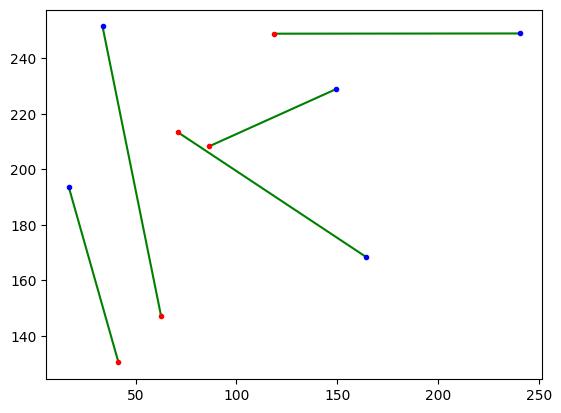

In [23]:
# Plot a green line between pairs of start points (blue) and transformed points (red).
nPoint = pts1Cart.shape[1]
for cPoint in range(0, nPoint):
    plt.plot([pts1Cart[0,cPoint], pts2Cart[0,cPoint]], [pts1Cart[1,cPoint], pts2Cart[1,cPoint]],'g-')
    plt.plot(pts1Cart[0,cPoint],pts1Cart[1,cPoint],'b.', pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.') 

plt.show()

It can be observed that the original points in blue have been displaced to the new positions in red after the homography has been applied. The individual transformation of each point is indicated by the green lines, highlighting the effect of the added noise.

## Homography estimation time!

We've formulated our test example; now our goal is to estimate the homography that maps the first set of points to the second set of points.

### ****TO DO****: Fill in the details of these routines (solveAXEqualsZero and calcBestHomography). 

In [24]:
def solveAXEqualsZero(A):
    # TO DO: Write this routine - it should solve Ah = 0. You can do this using SVD. Consult your notes! 
    # Hint: SVD will be involved. 
    # Perform the Singular Value Decomposition (SVD) of A
    U, S, VT = np.linalg.svd(A)
    
    # The last vector of VT (the last row of V, transposed) is the solution to Ah = 0
    # This is because it corresponds to the smallest singular value, which should be zero or close to zero
    h = VT[-1]
    
    return h

In [25]:
def calcBestHomography(pts1Cart, pts2Cart):
    
    # This function should apply the direct linear transform (DLT) algorithm to calculate the best 
    # homography that maps the cartesian points in pts1Cart to their corresonding matching cartesian poitns 
    # in pts2Cart.
    
    # This function calls solveAXEqualsZero. Make sure you are wary of how to reshape h into a 3 by 3 matrix. 

    n_points = pts1Cart.shape[1]
    
    # TO DO: replace this:
    #H = np.identity(3)
    pts1Hom = np.concatenate((pts1Cart, np.ones((1, pts1Cart.shape[1]))), axis=0)
    pts2Hom = np.concatenate((pts2Cart, np.ones((1, pts2Cart.shape[1]))), axis=0)

    # TO DO: 
    # First convert points into homogeneous representation
    # Hint: we've done this before in the skeleton code we provide.
    
    # Then construct the matrix A, size (n_points * 2, 9)
    # Consult the notes!

    # Construct the matrix A, where each point correspondence gives us two rows of A
    A = np.zeros((pts1Cart.shape[1] * 2, 9))
    for i in range(pts1Cart.shape[1]):
        X = pts1Hom[:, i]
        X_prime = pts2Hom[:, i]
        
        # Submatrix for the point correspondence
        A[2*i] = [-X[0], -X[1], -1, 0, 0, 0, X_prime[0]*X[0], X_prime[0]*X[1], X_prime[0]]
        A[2*i+1] = [0, 0, 0, -X[0], -X[1], -1, X_prime[1]*X[0], X_prime[1]*X[1], X_prime[1]]
    
    # Solve Ah = 0 using solveAXEqualsZero and get h.
    h = solveAXEqualsZero(A)

        # Reshape h into the matrix H, values of h go first into rows of H
    H = h.reshape((3, 3))

    
    return H

## Test time!

Time to put it all together. 

Now we need a way of measuring how well our mapping does. To do this we will apply our estimated mapping, `HEst`, to `pts1Cart` and obtain estimated points `pts2EstCart`. We will compare `pts2EstCart` and `pts2Cart` using a sum of squared difference to see how well our solution at least approximates the transformed noisy points `pts2Cart`.

Red points on the plot are the noisy points we observe, `pts2Cart`, and the magenta points are the transformed points, `pts2EstCart`, that we get when we apply our estimated homography on `pts1Cart`. The black lines represent the error between both points; if you've set `noiseLevel` to 0, then `sqDiff` should be 0 and the points should overlap perfectly.

Squared difference between pts2Cart and pts2EstCart is: 36.28


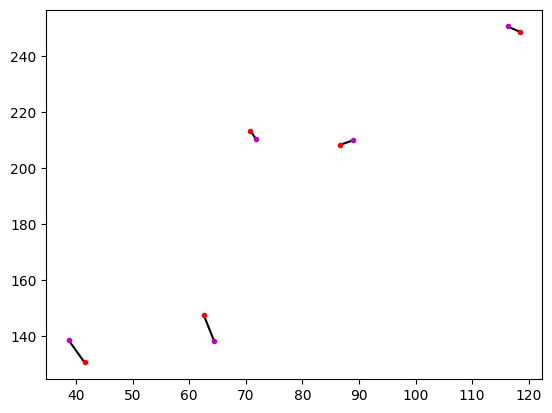

In [27]:
# Replace this with a call to the function calcBestHomography. You'll need to figure out which way around the 
# points go in the function, i.e. which direction this homography transforms points from and to. The ordering 
# is dead simple for now but acts as a simple exercise for what comes in later parts of this practical.
HEst = calcBestHomography(pts1Cart, pts2Cart)

# Apply estimated homography to points
pts2EstHom = np.matmul(HEst,pts1Hom)

# Convert back to Cartesian coordinates
pts2EstCart = pts2EstHom[0:2,:] / np.tile([pts2EstHom[2,:]],(2,1))

# Calculate the mean squared distance from actual points
sqDiff = np.mean(sum((pts2Cart - pts2EstCart)**2))

print("Squared difference between pts2Cart and pts2EstCart is: %.2f" % sqDiff)

# Draw figure with points before and after applying the estimated homography
nPoint = pts1Cart.shape[1]

# Plot a black line between pairs of actual points (red) and estimated points (magenta)
for cPoint in range(0, nPoint):
    plt.plot([pts2Cart[0,cPoint], pts2EstCart[0,cPoint]], [pts2Cart[1,cPoint], pts2EstCart[1,cPoint]],'k-')
    plt.plot(pts2Cart[0,cPoint],pts2Cart[1,cPoint],'r.',pts2EstCart[0,cPoint],pts2EstCart[1,cPoint],'m.') 

plt.show()

# Sqaured difference between pts2Cart and pts2EstCart is: 8305.33


The image displays the estimated transformed points, in magent, obtained by applying the estimated homography to the original points. The observed noisy points are shown in red and the lines illustrate the error between the estimated and observed points. The small squared difference of 2.72 suggests that the homography estimation is accurate, effectively capturing the transformation despite the added noise.

## Other things **** TO DO ****

1: Convince yourself that the homography is ambiguous up to scale (by
multiplying it by a constant factor and showing it does the same thing).
Can you see why this is the case mathematically?

A homography \( H \) transforms points in homogeneous coordinates $$ \mathbf{p} = (x, y, 1)^T $$ on a plane, resulting in a transformed point $$ \mathbf{p'} = (x', y', w')^T $$
$$
\mathbf{p'} = H \mathbf{p}
$$

When scaling the homography by a non-zero scalar factor alpha, we obtain alpha H. Applying this new matrix \( \alpha H \) to \( \mathbf{p} \) gives us:

$$
\alpha \mathbf{p'} = \alpha H \mathbf{p}
$$

In homogeneous coordinates, this can be written as \(x'', y'', w'')^T = alpha(x', y', w')^T. To convert back to Cartesian coordinates, it is divided by \( w'' \):

$$
\left( \frac{x''}{w''}, \frac{y''}{w''} \right) = \left( \frac{\alpha x'}{\alpha w'}, \frac{\alpha y'}{\alpha w'} \right) = \left( \frac{x'}{w'}, \frac{y'}{w'} \right)
$$

This mathematic approach shows that the scalar alpha cancels, leaving us with the same Cartesian coordinates as if we had applied the original homography without the scaling factor. Therefore, the homography is effectively ambiguous up to scale. 

2: Show empirically that your homography routine can EXACTLY map any four points to any other four points.

In [19]:
# Redefining the sets of points for the homography calculation
# Define a new set of four two-dimensional Cartesian points
pts1Cart_new = np.array([[240.5000, 16.8351, 33.5890, 164.2696],
                         [248.8770, 193.5890, 251.3901, 168.4581]])

# Define the corresponding destination points
pts2Cart_new = np.array([[251, 103, 160, 30],  # x-coordinates for destination
                         [30, 10, 210, 176]])  # y-coordinates for destination

# Now calculate the homography with these point sets
HEst_new = calcBestHomography(pts1Cart_new, pts2Cart_new)

# Apply the estimated homography to the original points
pts1Hom_new = np.concatenate((pts1Cart_new, np.ones((1, pts1Cart_new.shape[1]))), axis=0)
pts2EstHom_new = np.matmul(HEst_new, pts1Hom_new)

# Convert back to Cartesian coordinates
pts2EstCart_new = pts2EstHom_new[0:2,:] / np.tile([pts2EstHom_new[2,:]], (2,1))

# Calculate the mean squared error between the estimated points and the destination points
error_new = np.mean(np.sum((pts2EstCart_new - pts2Cart_new)**2, axis=0))

error_new



7.37186367309535e-22

In [20]:
# Translating the code to English for defining another set of alternative destination points
# Define another set of alternative destination points
pts2Cart_alternative = np.array([[300, 120, 200, 50],  # x-coordinates for destination
                                 [60, 20, 250, 190]])  # y-coordinates for destination

# Calculate the homography with the new set of destination points
HEst_alternative = calcBestHomography(pts1Cart_new, pts2Cart_alternative)

# Apply the estimated homography to the original points
pts2EstHom_alternative = np.matmul(HEst_alternative, pts1Hom_new)

# Convert back to Cartesian coordinates
pts2EstCart_alternative = pts2EstHom_alternative[0:2,:] / np.tile([pts2EstHom_alternative[2,:]], (2,1))

# Calculate the mean squared error between the estimated points and the alternative destination points
error_alternative = np.mean(np.sum((pts2EstCart_alternative - pts2Cart_alternative)**2, axis=0))

error_alternative


3.91821605031051e-21

The homography calculations have yielded results with high precision (errors closer to zero) for two different sets of four points, regardless of the specific choice of points. Each corresponding pair of points between the two planes contributes two degrees of freedom, represented by two linear equations, one for x and one for y. Consequently, four pairs of points provide the exact number of eight equations necessary to solve the homography. This one-to-one correspondence highlights why exactly four pairs of points are necessary and sufficient to determine a homography without leaving any degrees of freedom unresolved.